In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from my_modules import compute
from my_modules import visualize as vz

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
# color map
ce_cmap = sns.diverging_palette(30, 180, 90, 50, center='light', as_cmap=True)
interaction_cmap = sns.diverging_palette(0, 230, 90, 60, center='light', as_cmap=True)
plasticity_cmap = 'RdGy'

In [5]:
storage = os.environ['MICOM_EXP'] + 'setA_coculture_b12_c96/' # on Peregrine
print(storage)

meta_species = pd.read_csv(storage + "selected_species_setA.tsv", sep="\t")
meta_species

/data/s4278836/First_project/experiments/setA_coculture_b12_c96/


Ecotype Ecotype_ID Species_ID                             Species_name
0       I        I_a    setA_15                Helicobacter_pylori_26695
1       I        I_b    setA_21           Pseudomonas_nitroreducens_HBP1
2      II       II_a    setA_11               Eggerthella_lenta_DSM_2243
3      II       II_b    setA_24         Ruminococcus_lactaris_ATCC_29176
4     III      III_a     setA_6         Brevibacillus_brevis_NBRC_100599
5     III      III_b    setA_13  Escherichia_coli_str_K_12_substr_MG1655
6      IV       IV_a    setA_19             Odoribacter_laneus_YIT_12061
7      IV       IV_b    setA_20           Peptoniphilus_timonensis_JC401
8       V        V_a    setA_16              Lactobacillus_gastricus_PS3

In [6]:
data_dir = storage + 'features/'
culture_type = 'continuous'
media=['EU_avg', 'high_fat']

# for computing interaction coefficients
mono_data_dir = os.environ['MICOM_EXP'] + 'setA_mono_b12_c144/features/' # on Peregrine

# for competitive exclusion assessment
min_density=1.0e-2

In [7]:
# for annotating species with their "degree of plasticity" in mono-culture
mono_plasticity_file = "../setA_mono_b12_c144/features/log_fold_change.plasticity.tsv"

mono_plasticity = pd.read_csv(mono_plasticity_file, sep='\t', usecols=['species_ID', 'media', 'log_fold_change', 'culture_type'])

# to extract list of species ID in the correct order
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=True, min_survived=min_density,
                                                                intra=True, method='glv')

mono_plas = mono_plasticity.loc[(mono_plasticity['culture_type'] == culture_type) & (mono_plasticity['media'].isin(media)) &
                                (mono_plasticity['species_ID'].isin(plastic_meta['species_ID'])), :]

mono_plas = mono_plas.pivot(index='species_ID', columns='media', values='log_fold_change')
mono_plas = mono_plas.reindex(index=plastic_meta['species_ID'])
mono_plas = mono_plas.reindex(columns=media)

pmo_min = mono_plasticity['log_fold_change'].min() # min across all 18 species of set A & all 11 diets - to get negative value
print(pmo_min)
pmo_max = mono_plas.to_numpy().max()
print(pmo_max)

mono_plas

-0.009463740740957792
4.478131823042856


/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


media         EU_avg      high_fat
species_ID                        
setA_15     4.478132  1.337440e+00
setA_21     0.618262  2.446184e+00
setA_11     1.744466  3.203427e-16
setA_24     0.000000  1.472066e+00
setA_16     0.000011  1.018946e-04

# OD_dist

In [8]:
for medium in media:
    vz.plot_interaction_OD_dist(data_dir, mono_data_dir, culture_type, medium, fig_dir='./fig/')

<Figure size 432x288 with 0 Axes>

# Co-existence

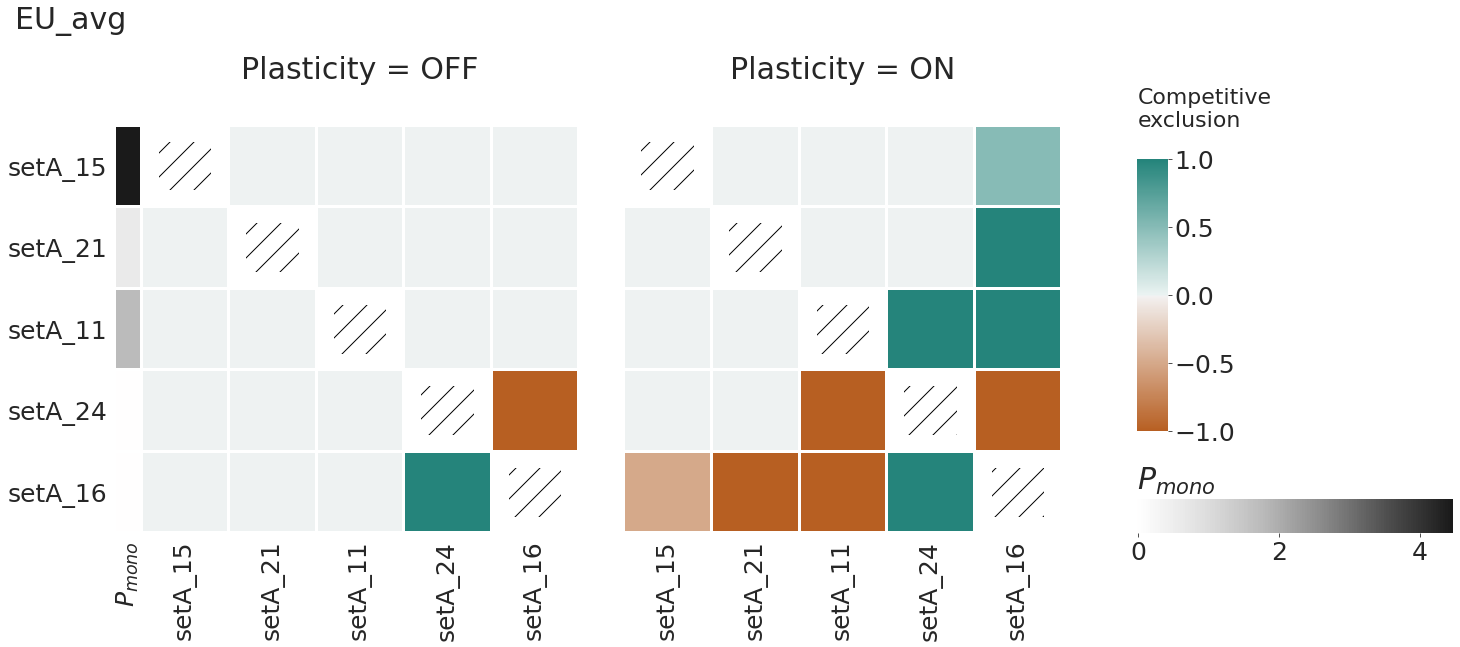

In [9]:
# EU_avg
i=0

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
# sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
# plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

# inter_cbar = fig.add_subplot(inner_cbar[6])
# inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=sfm_meta['species_ID'], yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=plastic_meta['species_ID'], yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_ce_mat.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_ce_mat.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
# inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/comp_excl.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')

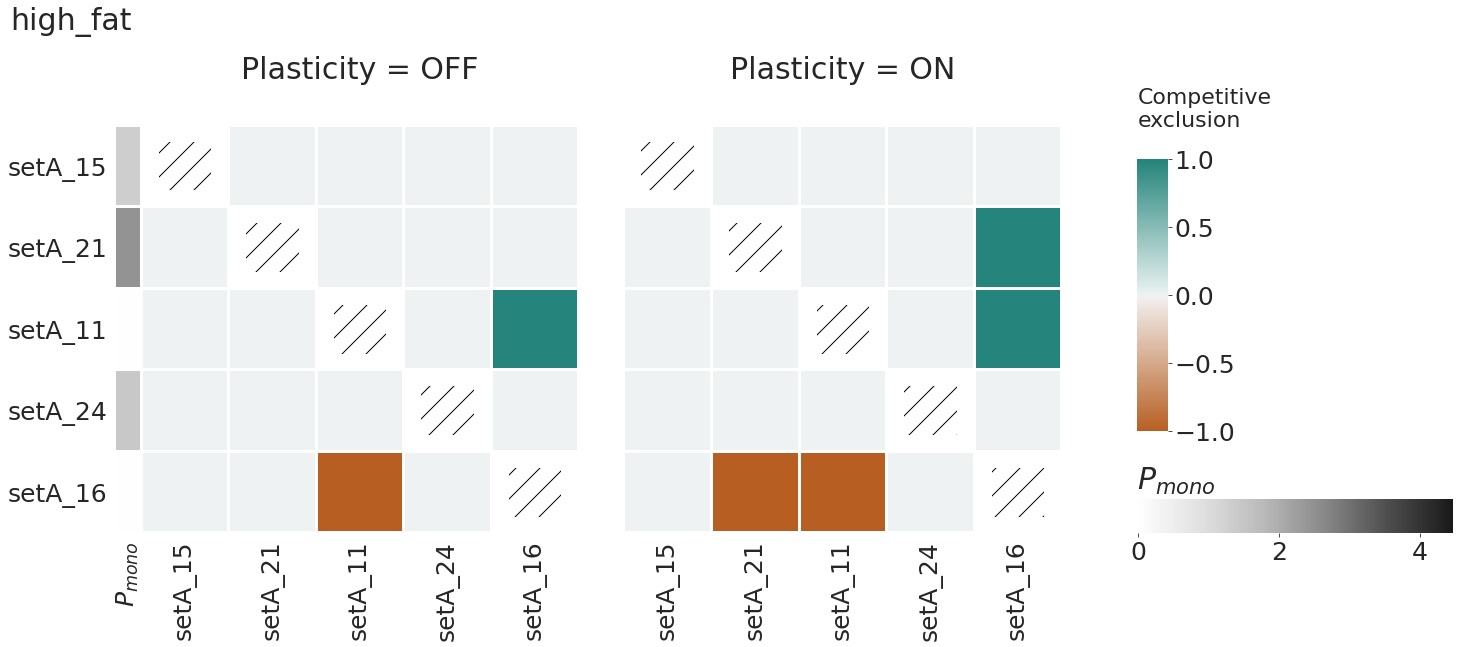

In [10]:
# high_fat
i=1

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
# sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
# plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

# inter_cbar = fig.add_subplot(inner_cbar[6])
# inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=sfm_meta['species_ID'], yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=plastic_meta['species_ID'], yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_ce_mat.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_ce_mat.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
# inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/comp_excl.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')

# Interaction coefficients

In [11]:
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=True, min_survived=min_density,
                                                                intra=True, method='glv')
sfm_interactions, sfm_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=False, 
                                                        rm_compet_excl=True, min_survived=min_density,
                                                        intra=True, method='glv')

pco_min = min(np.nanmin(sfm_interactions), np.nanmin(plastic_interactions))
print(pco_min)
pco_max = max(np.nanmax(sfm_interactions), np.nanmax(plastic_interactions))
print(pco_max)

-4.265728253371591
0.2180981672788436


/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


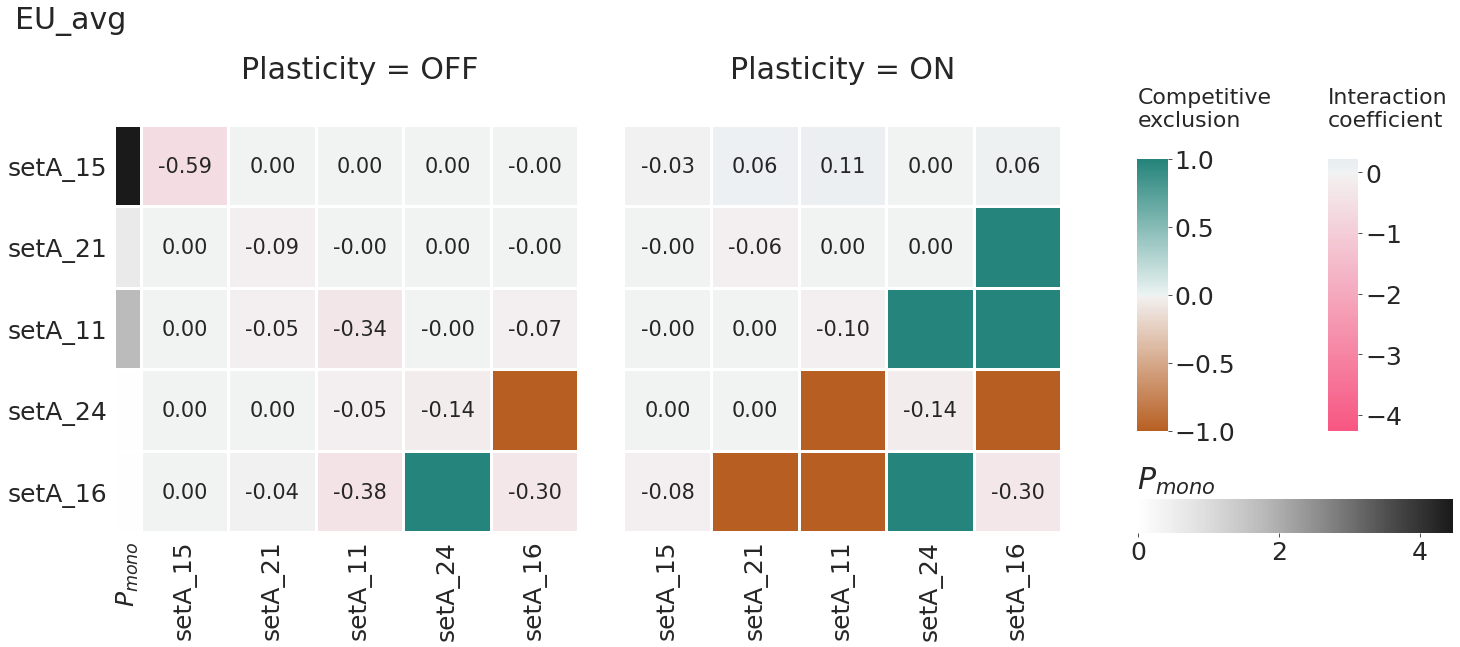

In [12]:
# EU_avg
i=0

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[6])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Interaction terms
# pco_min = min(np.nanmin(sfm_interactions[i,:,:]), np.nanmin(plastic_interactions[i,:,:]))
# pco_max = max(np.nanmax(sfm_interactions[i,:,:]), np.nanmax(plastic_interactions[i,:,:]))

sns.heatmap(sfm_interactions[i,:,:], xticklabels=sfm_meta['species_ID'], yticklabels=False, 
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(plastic_interactions[i,:,:], xticklabels=plastic_meta['species_ID'], yticklabels=False,
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/inter_intra_coeff.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')

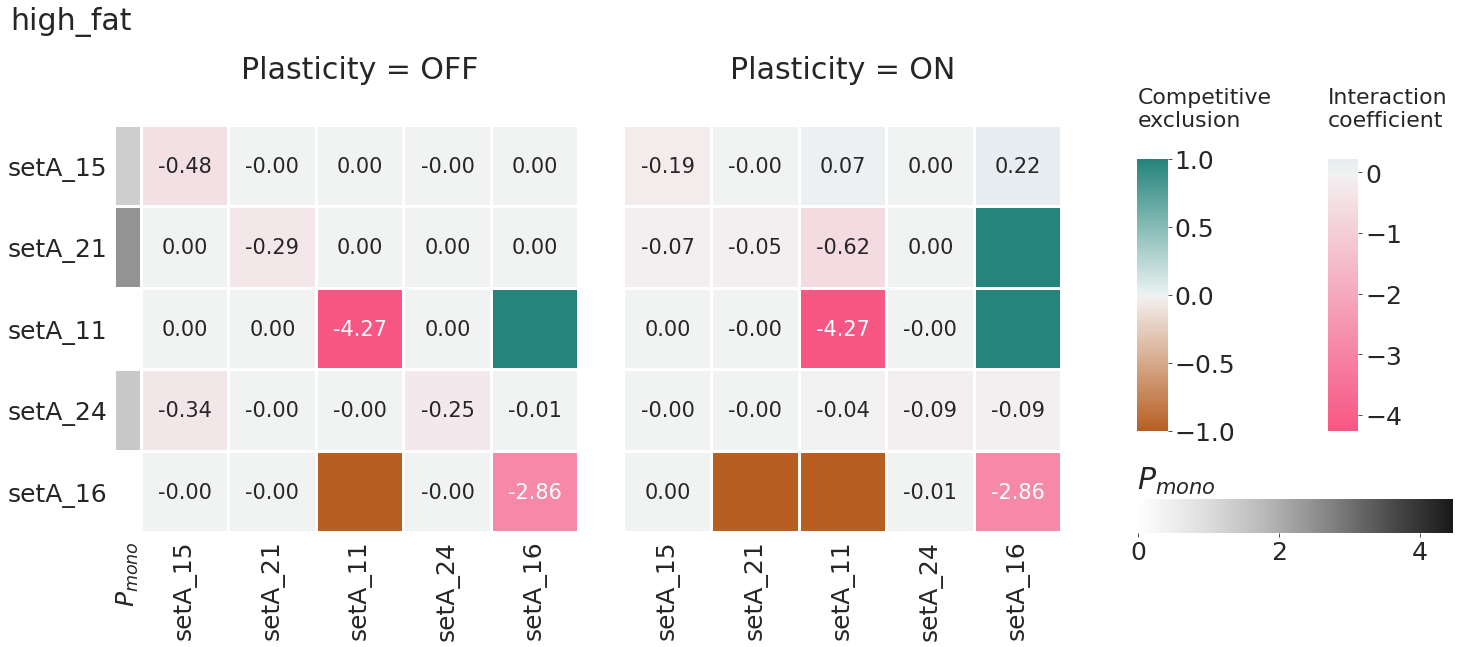

In [13]:
# high_fat
i=1

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[6])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Interaction terms
# pco_min = min(np.nanmin(sfm_interactions[i,:,:]), np.nanmin(plastic_interactions[i,:,:]))
# pco_max = max(np.nanmax(sfm_interactions[i,:,:]), np.nanmax(plastic_interactions[i,:,:]))

sns.heatmap(sfm_interactions[i,:,:], xticklabels=sfm_meta['species_ID'], yticklabels=False, 
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=sfm_hm)

sns.heatmap(plastic_interactions[i,:,:], xticklabels=plastic_meta['species_ID'], yticklabels=False,
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=inter_cbar, ax=plastic_hm)

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/inter_intra_coeff.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')

In [14]:
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=True, min_survived=min_density,
                                                                intra=False, method='glv')
sfm_interactions, sfm_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=False, 
                                                        rm_compet_excl=True, min_survived=min_density,
                                                        intra=False, method='glv')

pco_min = min(np.nanmin(sfm_interactions), np.nanmin(plastic_interactions))
print(pco_min)
pco_max = max(np.nanmax(sfm_interactions), np.nanmax(plastic_interactions))
print(pco_max)

-0.6244792324155799
0.2180981672788436


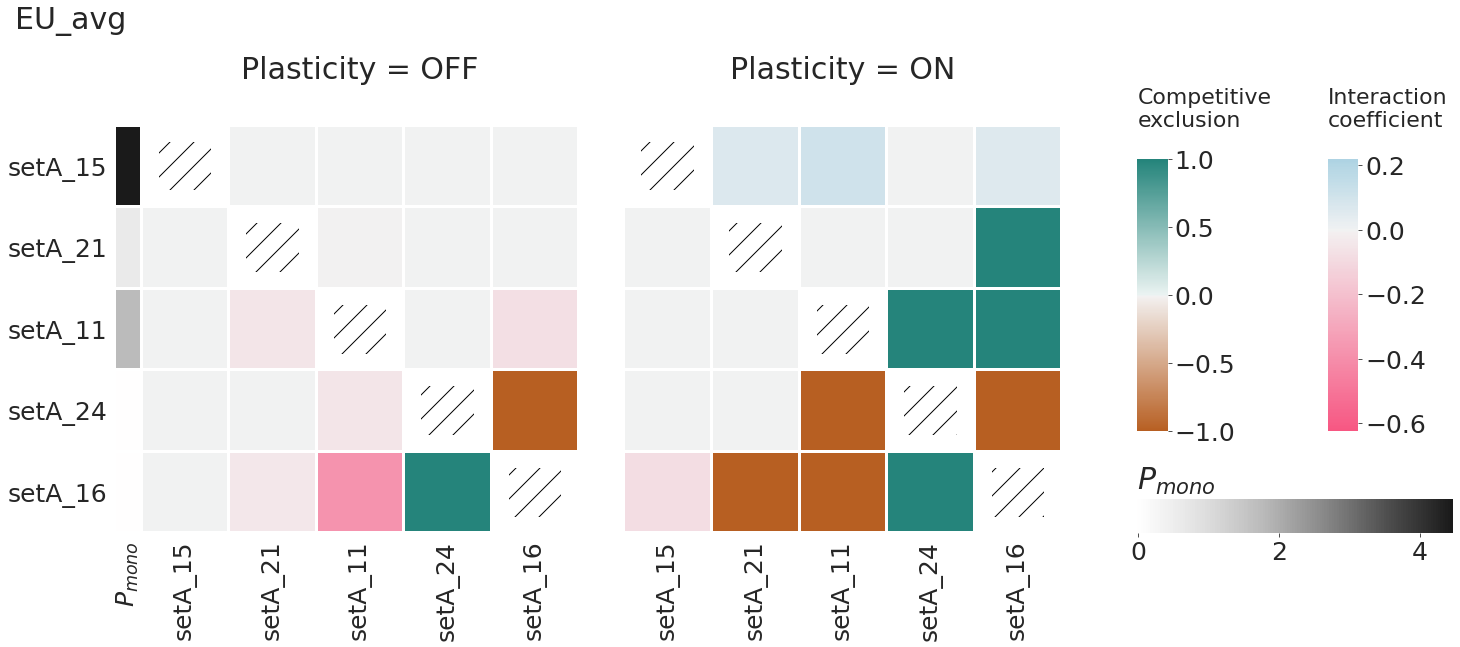

In [15]:
# EU_avg
i=0

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[6])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Interaction terms
# pco_min = min(np.nanmin(sfm_interactions[i,:,:]), np.nanmin(plastic_interactions[i,:,:]))
# pco_max = max(np.nanmax(sfm_interactions[i,:,:]), np.nanmax(plastic_interactions[i,:,:]))

sns.heatmap(sfm_interactions[i,:,:], xticklabels=sfm_meta['species_ID'], yticklabels=False, 
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            cbar=False, ax=sfm_hm)

sns.heatmap(plastic_interactions[i,:,:], xticklabels=plastic_meta['species_ID'], yticklabels=False,
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            cbar_ax=inter_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_interactions.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_interactions.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/inter_coef.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')

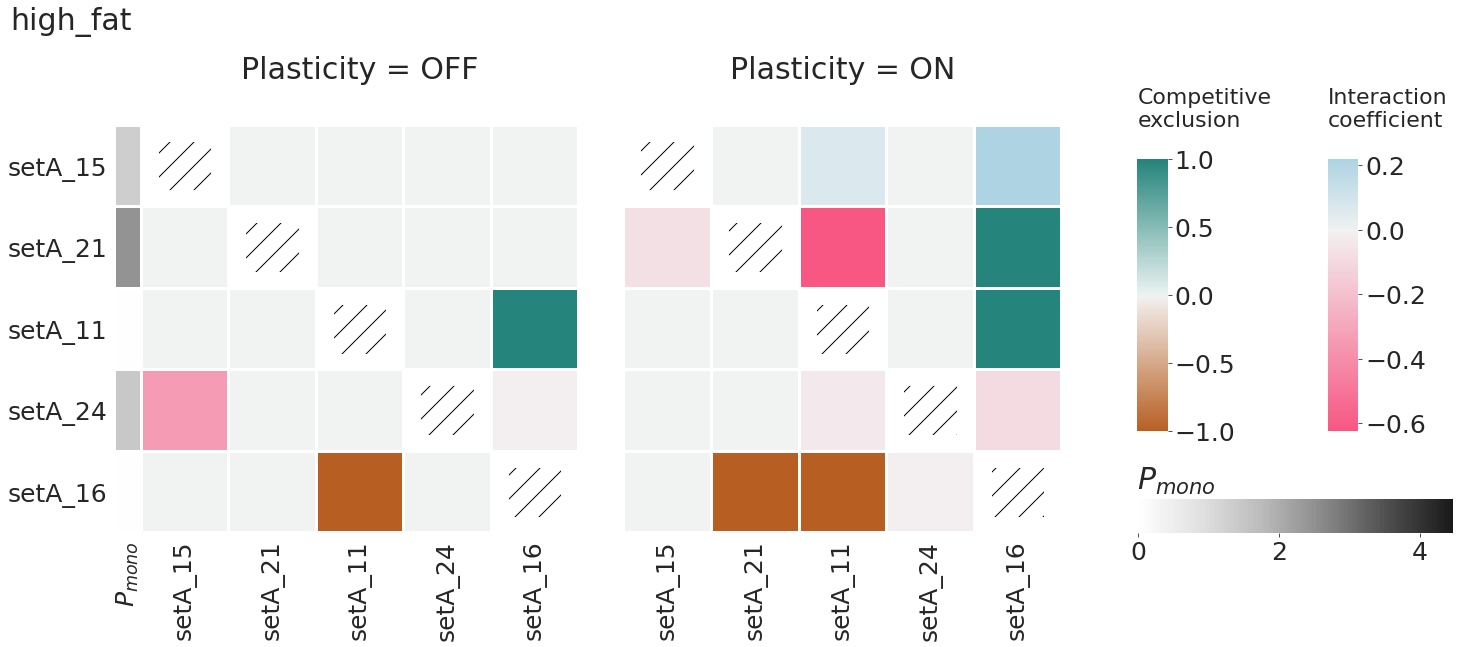

In [16]:
# high_fat
i=1

sfm_ce_stack, sfm_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=False, min_survived=min_density)
sfm_ce_mat = sfm_ce_stack.mean(axis=0)
sfm_ce_mat[sfm_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

plastic_ce_stack, plastic_meta = compute.competitive_exclusion_stack(data_dir, culture_type, media[i], plastic=True, min_survived=min_density)
plastic_ce_mat = plastic_ce_stack.mean(axis=0)
plastic_ce_mat[plastic_ce_mat == 0.0] = np.nan # remove communities where there is no competitive exclusion

# Plotting
fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

ce_cbar = fig.add_subplot(inner_cbar[0])
ce_cbar.set_title('Competitive\nexclusion', fontdict={'fontsize':22}, loc='left', y=1.1)

inter_cbar = fig.add_subplot(inner_cbar[6])
inter_cbar.set_title('Interaction\ncoefficient', fontdict={'fontsize':22}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Competitive exclusion
sns.heatmap(data=sfm_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0,
            cmap=ce_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_ce_mat, vmin=-1.0, vmax=1.0,
            xticklabels=False, yticklabels=False, linewidths=2.0, 
            cmap=ce_cmap, square=True, cbar_ax=ce_cbar, ax=plastic_hm)

# Interaction terms
# pco_min = min(np.nanmin(sfm_interactions[i,:,:]), np.nanmin(plastic_interactions[i,:,:]))
# pco_max = max(np.nanmax(sfm_interactions[i,:,:]), np.nanmax(plastic_interactions[i,:,:]))

sns.heatmap(sfm_interactions[i,:,:], xticklabels=sfm_meta['species_ID'], yticklabels=False, 
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            cbar=False, ax=sfm_hm)

sns.heatmap(plastic_interactions[i,:,:], xticklabels=plastic_meta['species_ID'], yticklabels=False,
            vmin=pco_min, vmax=pco_max, center=0.0, cmap=interaction_cmap, square=True, linewidths=2.0, 
            cbar_ax=inter_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction 
sfm_patch = [(a+0.2, a+0.2) for a in range(sfm_interactions.shape[1])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, a+0.2) for a in range(plastic_interactions.shape[1])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

ce_cbar.axis('tight')
inter_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/inter_coef.cont_' + media[i] + '.svg', transparent=True, bbox_inches='tight')